In [1]:
# =====================================================
# Gesture Classification from Sequential Data
# Task 1 (CRISP-DM + Preprocessing + Visualization)
# Task 2 (Sequential Classifiers: RNN, LSTM, BiLSTM, GRU)
# =====================================================

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# ------------------------------
# 1. Load and Label Data
# ------------------------------
DATA_PATH = "combined_extracted/combined"  # folder with all .txt files

sequences, labels = [], []
for filename in os.listdir(DATA_PATH):
    if filename.endswith(".txt"):
        gesture = filename.split("_")[0]  # label = gesture name
        file_path = os.path.join(DATA_PATH, filename)
        data = np.loadtxt(file_path)      # shape: (timesteps, 60)
        sequences.append(data)
        labels.append(gesture)

print(f"Loaded {len(sequences)} sequences for {len(set(labels))} gestures")

Loaded 2700 sequences for 30 gestures


In [2]:
# ------------------------------
# 2. Encode Labels
# ------------------------------
le = LabelEncoder()
y = le.fit_transform(labels)
num_classes = len(np.unique(y))
print("Gesture classes:", le.classes_)

# ------------------------------
# 3. Normalize Features
# ------------------------------
# Flatten to fit scaler, then reshape back
all_data = np.vstack(sequences)
scaler = StandardScaler()
scaler.fit(all_data)

sequences_scaled = [scaler.transform(seq) for seq in sequences]

Gesture classes: ['afternoon' 'baby' 'big' 'born' 'bye' 'calendar' 'child' 'cloud' 'come'
 'daily' 'dance' 'dark' 'day' 'enjoy' 'go' 'hello' 'home' 'love' 'my'
 'name' 'no' 'rain' 'sorry' 'strong' 'study' 'thankyou' 'welcome' 'wind'
 'yes' 'you']


Training shape: (2160, 189, 60)
Testing shape: (540, 189, 60)


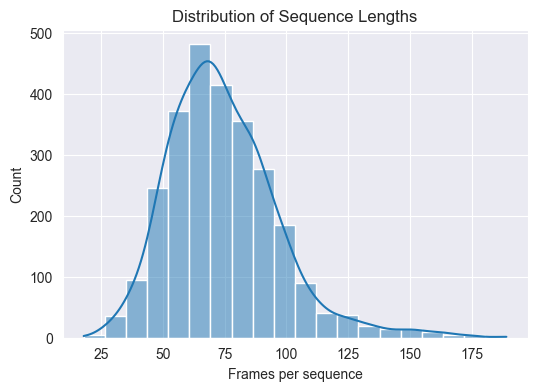

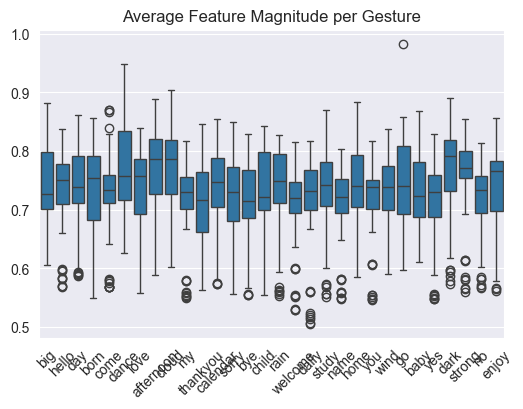

In [3]:
from keras.src.utils import pad_sequences, to_categorical

# ------------------------------
# 4. Pad Sequences
# ------------------------------
max_len = max(seq.shape[0] for seq in sequences_scaled)
X = pad_sequences(sequences_scaled, maxlen=max_len, padding='post', dtype='float32')

y_cat = to_categorical(y, num_classes=num_classes)
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y_cat, random_state=42)

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)

# ------------------------------
# 5. Visualization & Descriptive Analysis
# ------------------------------
# a. Sequence lengths
lengths = [len(seq) for seq in sequences]
plt.figure(figsize=(6,4))
sns.histplot(lengths, bins=20, kde=True)
plt.title("Distribution of Sequence Lengths")
plt.xlabel("Frames per sequence")
plt.ylabel("Count")
plt.show()

# b. Mean feature values per gesture
means = [np.mean(seq, axis=0).mean() for seq in sequences]
plt.figure(figsize=(6,4))
sns.boxplot(x=labels, y=means)
plt.title("Average Feature Magnitude per Gesture")
plt.xticks(rotation=45)
plt.show()

In [10]:

from keras.src.layers import Masking, SimpleRNN, Dense, LSTM, Bidirectional, GRU, Dropout
from keras import Sequential, Input


# =====================================================
# Task 2 — Train Sequential Classifiers
# =====================================================

def build_rnn(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Masking(mask_value=0.0),
        SimpleRNN(64),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_lstm(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Masking(mask_value=0.0),
        LSTM(128, return_sequences=False),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_bilstm(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),                    
        Masking(mask_value=0.0),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.4),
        Bidirectional(LSTM(32)),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_gru(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Masking(mask_value=0.0),
        GRU(128),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
from keras.src.callbacks import EarlyStopping


# ------------------------------
# 6. Training Function
# ------------------------------
def train_and_evaluate(model, name):
    print(f"\nTraining {name}...")
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train,
                        validation_split=0.2,
                        epochs=50,
                        batch_size=16,
                        callbacks=[early_stop],
                        verbose=1)
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"{name} Test Accuracy: {acc*100:.2f}%")

    # Plot training curves
    plt.figure(figsize=(7,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{name} Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return acc, loss


Training RNN...
Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.0448 - loss: 3.4248 - val_accuracy: 0.1782 - val_loss: 2.7677
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1946 - loss: 2.6178 - val_accuracy: 0.2963 - val_loss: 2.1284
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.2921 - loss: 2.1323 - val_accuracy: 0.3704 - val_loss: 1.8289
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3903 - loss: 1.8255 - val_accuracy: 0.4769 - val_loss: 1.6103
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4290 - loss: 1.6292 - val_accuracy: 0.4977 - val_loss: 1.4742
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4912 - loss: 1.4938 - val_accuracy: 0.5394 - val_loss: 1.3985
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4794 - loss: 1.4866 - val_accuracy: 0.5417 - val_loss: 1.2974
Epoch 8/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5450 - loss: 

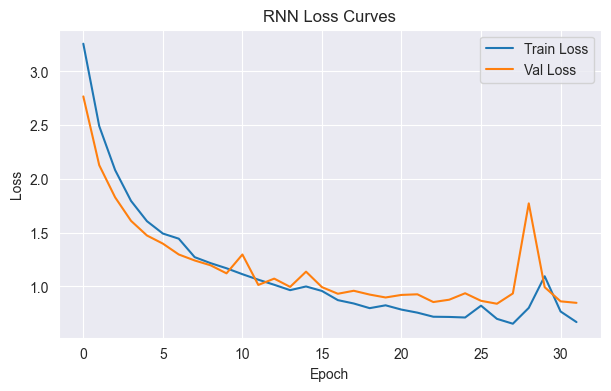


Training LSTM...
Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.0832 - loss: 3.3086 - val_accuracy: 0.3287 - val_loss: 2.4164
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.3083 - loss: 2.2541 - val_accuracy: 0.3495 - val_loss: 1.8330
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.4035 - loss: 1.7910 - val_accuracy: 0.5069 - val_loss: 1.5394
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.4817 - loss: 1.5489 - val_accuracy: 0.5463 - val_loss: 1.3092
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.5162 - loss: 1.3964 - val_accuracy: 0.5949 - val_loss: 1.1893
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.5578 - loss: 1.2960 - val_accuracy: 0.5856 - val_loss: 1.1528
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.5418 - loss: 1.3441 - val_accuracy: 0.5417 - val_loss: 1.2661
Epoch 8/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.5286 - loss:

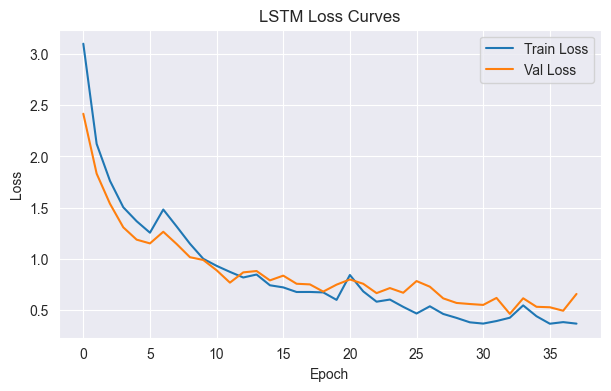


Training BiLSTM...
Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.0770 - loss: 3.3048 - val_accuracy: 0.2569 - val_loss: 2.5122
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - accuracy: 0.2513 - loss: 2.3677 - val_accuracy: 0.4028 - val_loss: 1.8306
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - accuracy: 0.3850 - loss: 1.8412 - val_accuracy: 0.5394 - val_loss: 1.4802
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - accuracy: 0.4782 - loss: 1.5539 - val_accuracy: 0.5648 - val_loss: 1.2894
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - accuracy: 0.5468 - loss: 1.3558 - val_accuracy: 0.5856 - val_loss: 1.2157
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - accuracy: 0.5503 - loss: 1.2528 - val_accuracy: 0.6319 - val_loss: 1.0289
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 0.5975 - loss: 1.1201 - val_accuracy: 0.6296 - val_loss: 1.0310
Epoch 8/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - accurac

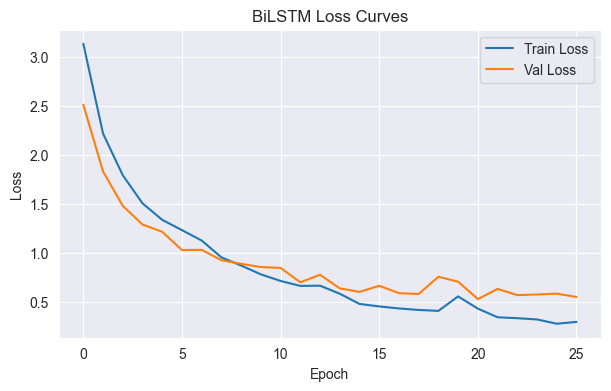


Training GRU...
Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.0764 - loss: 3.3721 - val_accuracy: 0.2523 - val_loss: 2.5492
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.2749 - loss: 2.3639 - val_accuracy: 0.4630 - val_loss: 1.6719
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.4559 - loss: 1.6742 - val_accuracy: 0.5718 - val_loss: 1.3088
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.5344 - loss: 1.3700 - val_accuracy: 0.6042 - val_loss: 1.1478
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.6029 - loss: 1.1505 - val_accuracy: 0.6736 - val_loss: 1.0149
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.6489 - loss: 1.0138 - val_accuracy: 0.6921 - val_loss: 0.8817
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.6982 - loss: 0.8687 - val_accuracy: 0.7546 - val_loss: 0.7251
Epoch 8/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.7037 - loss: 

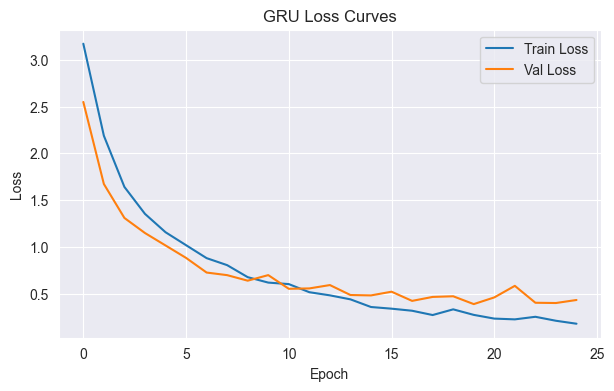

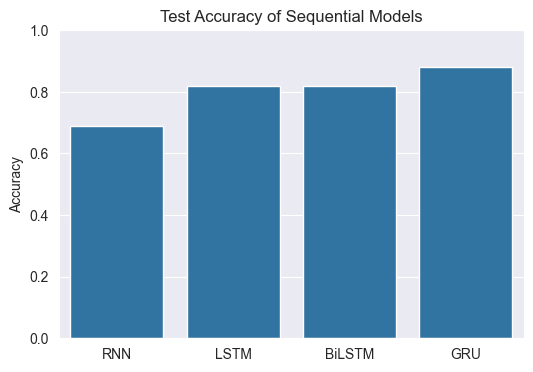


Final Accuracy Comparison:
RNN: 68.89%
LSTM: 82.04%
BiLSTM: 82.04%
GRU: 88.15%


In [12]:
# ------------------------------
# 7. Train Models
# ------------------------------
input_shape = (max_len, X.shape[2])
results = {}

for name, builder in [("RNN", build_rnn),
                      ("LSTM", build_lstm),
                      ("BiLSTM", build_bilstm),
                      ("GRU", build_gru)]:
    model = builder(input_shape, num_classes)
    acc, loss = train_and_evaluate(model, name)
    results[name] = acc

# ------------------------------
# 8. Compare Model Performance
# ------------------------------
plt.figure(figsize=(6,4))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Test Accuracy of Sequential Models")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()

print("\nFinal Accuracy Comparison:")
for model_name, acc in results.items():
    print(f"{model_name}: {acc*100:.2f}%")